#  Reinforcement Learning Fundamentals Assignment

Here you will use tabular Q-learning to develop a policy for the [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment in Gymnasium. In the Cart Pole problem, the aim is to keep a vertical pole balanced on top of a cart. You can apply forces to move the cart right or left, which affects the position and velocity of the cart, as well as the angle and angular velocity of the pole.

To complete the assignment, please do the following:
1. Read the [Cart Pole documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to get an understanding of the states, actions, and rewards associated with this environment.
2. Propose a method for discretizing the state space. This problem has a continuous state space, unlike the Blackjack environment that we worked with previously. This presents a challenge, since tabular Q-learning requires the problem to have a finite state space. We will address this by mapping the each of the problem's continuous states to a state in an approximate finite state space. When selecting your finite state space, you will need to strike the right balance between using an apporoximation that is sufficiently granular to be accurate, but not so granular that the resulting state space is too large to effectively implement tabular Q-learning.
3. Implement tabular Q-learning to compute a policy for the Cart Pole problem. You may reuse code from the Blackjack notebook that we used in class.
4. Simulate your policy in the cartpole environment. Can you keep the pole balanced for at least 500 time steps?

---

Before you get started, we will set up and demonstrate the Cart Pole environment.

In [ ]:
!pip install gymnasium
!pip install gymnasium[classic-control]

In [ ]:
import gymnasium as gym
import numpy as np
import random

from IPython import display
import matplotlib.pyplot as plt

Here we simulate the environment with the following simple heuristic policy:
- If the pole is leaning to the left, push the cart to the left
- If the pole is leaning to the right, push the cart to the right

As you can see, this policy is actually unstable. The pole will quickly fall and the cart will run off the screen.

**NOTE:** The animations of the environment can look glitchy if you run them directly in Colab. Run the notebook locally to see smoother animations.

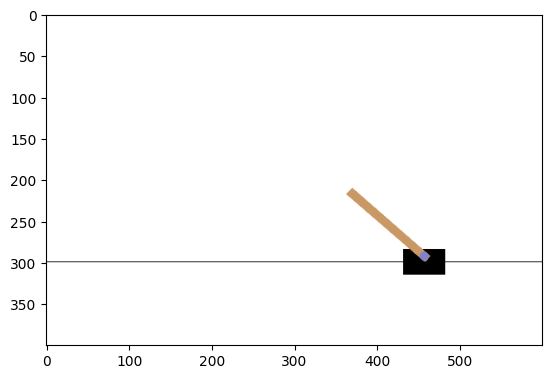

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

obs = env.reset()[0]
plt.imshow(env.render())
plt.show()

for i in range(250):

    if obs[2] < 0:
        action=0
    else:
        action=1

    obs, reward, done, info, other = env.step(action)

    display.clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

env.close()

---

To discretize the state space, we could simply round down all of the continuous components of the state to the nearest integer. For this problem, it is important to round down (or round up) rather than rounding to the nearest integer. To understand why, consider the cases when the pole is angled slightly to the left of vertical versus slightly to the right of vertical. If we round the angle to the nearest integer, the angle will be rounded to zero in both cases. However, intuitively we want to respond to these two cases differently. Rounding down or up will preserve the distinction between these two cases.

Simply rounding all components of the state down will yield a policy that is capable of occasionally balancing the pole for 500 time steps. However, we can obtain a policy that achieves this goal more reliably if we use a finer discretization of the state space. As mentioned above, we need to take care to strike the right balance between using an apporoximation that is sufficiently granular to be accurate, but not so granular that the resulting state space is too large to effectively implement tabular Q-learning.

After some experimentation, we arrived at the observation that increasing the resolution of the angle and angular velocity has a greater impact on the resulting policy that increasing the resolution of the position and velocity. As a result, we will use a discretization that rounds the position and velocity down in increments of 0.5, and rounds the angle and angular velocity down in increments of 0.2.

In [ ]:
# Implement your Q-learning code here

env = gym.make('CartPole-v1', render_mode="rgb_array")

n_games = 250000

g = 0.98

a = 0.05
e = 0.05

Q = {}
Q[("done", 0)] = 0
Q[("done", 1)] = 0

for i in range(n_games):

    if i%1000 == 0:
        print(f"\r{i} episodes run...", end="")

    state = env.reset()[0]
    # Discretize obs as described above
    state[0] = 2*state[0]
    state[1] = 2*state[1]
    state[2] = 5*state[2]
    state[3] = 5*state[3]
    obs = tuple(np.floor(state))

    if (obs, 0) not in Q:
        Q[(obs, 0)] = 0.0
    if (obs, 1) not in Q:
        Q[(obs, 1)] = 0.0

    done = False
    while done is False:

        # Implement epsilon-greedy
        if random.random() < e:
            action = env.action_space.sample()
        elif Q[(obs, 0)] > Q[(obs, 1)]:
            action = 0
        else:
            action = 1

        obs_prev = obs
        state, reward, done, info, other = env.step(action)
        # Discretize obs as described above
        state[0] = 2*state[0]
        state[1] = 2*state[1]
        state[2] = 5*state[2]
        state[3] = 5*state[3]
        obs = tuple(np.floor(state))
        if done:
            obs = "done"

        if (obs, 0) not in Q:
            Q[(obs, 0)] = 0.0
        if (obs, 1) not in Q:
            Q[(obs, 1)] = 0.0

        maxQ = max(Q[(obs, 0)], Q[(obs, 1)])
        Q[(obs_prev, action)] = (1-a)*Q[(obs_prev, action)] + a*(reward + g*maxQ)

env.close()

249000 episodes run...

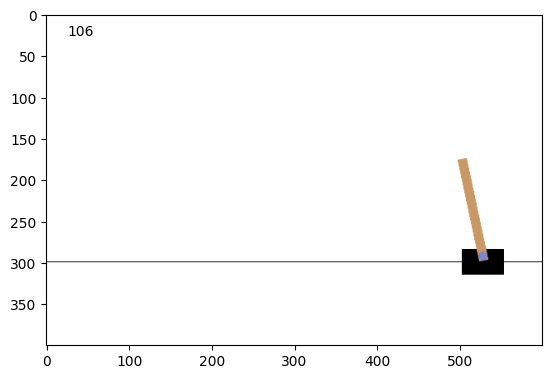

In [ ]:
# Implement the simulation of your policy here

env = gym.make('CartPole-v1', render_mode="rgb_array")

state = env.reset()[0]
state[0] = 2*state[0]
state[1] = 2*state[1]
state[2] = 5*state[2]
state[3] = 5*state[3]
obs = tuple(np.floor(state))

plt.imshow(env.render())
plt.show()

for i in range(500):

    if (obs, 0) not in Q:
        action = env.action_space.sample()
    elif Q[(obs, 0)] > Q[(obs, 1)]:
        action = 0
    else:
        action = 1

    state, reward, done, info, other = env.step(action)
    if done:
        break
    state[0] = 2*state[0]
    state[1] = 2*state[1]
    state[2] = 5*state[2]
    state[3] = 5*state[3]
    obs = tuple(np.floor(state))

    display.clear_output(wait=True)
    plt.imshow(env.render())
    plt.text(25,25,i)
    plt.show()

env.close()